In [64]:
import pandas as pd 
import numpy as np 
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import warnings
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter


In [65]:
# Ignore DeprecationWarning and FutureWarning messages
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
#Set the maximum number of columns & rows to be displayed 
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_colwidth', 20)

Ignoring DeprecationWarning and FutureWarning messages should be done with caution and only in specific situations where you have a good reason to do so.

Generally, it is not recommended to ignore warning messages by default, as they often provide important information about potential issues in your code or upcoming changes in Python or its libraries. 

# 1. Data Preprocessing and Cleaning
## 1-1 Data Import and Initial Exploration

In [66]:
# import the dataset
df = pd.read_csv('resume_with_job_description.csv')

In [67]:
df.head()

,id,content,jobDescription
0,clg43d9an007gx02...,"{""awards"": {""awa...",Job Posting:\nDo...
1,clg3itetj006jx92...,"{""awards"": {""awa...",Tasks:\n\nCreati...
2,clg3iy1sd007rx32...,"{""awards"": {""awa...",Responsibilities...
3,clg5j15lz00k3x02...,"{""awards"": {""awa...",What is Talentpo...
4,clg43pte600ddya2...,"{""awards"": {""awa...",Hyperproof is hi...


In [68]:
print("Number of unique IDs in DF:", df['id'].nunique())

Number of unique IDs in DF: 11976


This dataset contains nested JSON objects, with the aim of preparing the data for customer profile
analysis. Our efforts resulted in one readable and analyzable datasets, and we obtained
preliminary findings that lay a solid foundation for future analysis.

## 1-2 Data preprocessing: JSON Flattening
### 1-2-1 Step1: Flattening First-layer Objects

In [69]:
# Convert JSON-fomated 'content' strings to Python dictionary objects
df['content'] = df['content'].apply(json.loads)

In [70]:
# Flatten the first-layer Json object into a dataframe
d1 = pd.json_normalize(df['content'], sep='_', # nested keys joined by _
                        errors='ignore' # in case some JSON objects have missing or inconsistent data.
                        )

In [71]:
d1.head()

,keywords,suggestedSkills,...,accomplishments_visible,accomplishments_diffedText
0,[admissions repr...,"[Compliance, Cli...",...,True,
1,[dashboard inter...,"[Analysis, Colle...",...,True,
2,"[product, desig...","[Vue, DevOps, De...",...,True,
3,"[flexibility, i...",[],...,True,
4,[product roadmap...,[Curiosity],...,True,


After flattening, we've got **columns containing strings** and **columns containing lists of nested objects("[]")**. 

In [72]:
# Rename the columns for easier reference
d1.rename(columns={'awards_awards':'awards','header_contact_city': 'city', 'header_contact_state': 'state', 'skills_skills': 'skills',
                              'header_contact_country':'country','projects_projects':'project','volunteer_volunteer':'volunteer','experience_experience':'experience',
                              'references_references':'references','publications_publications':'publications','certifications_certifications':'certifications',
                              'education_education':'education'}, inplace=True)
# Drop the 'header_role' column as it doesn't contain any value.
d1.drop(['header_role'], axis=1, inplace=True)

In [73]:
d1.head()

,keywords,suggestedSkills,...,accomplishments_visible,accomplishments_diffedText
0,[admissions repr...,"[Compliance, Cli...",...,True,
1,[dashboard inter...,"[Analysis, Colle...",...,True,
2,"[product, desig...","[Vue, DevOps, De...",...,True,
3,"[flexibility, i...",[],...,True,
4,[product roadmap...,[Curiosity],...,True,


- **'keywords', 'suggestedSkills'** contains lists of words and no dictionaries. Since words don't follow a pattern in categories, these two columns do not to be extracted
- **'awards', 'skills','project','education','volunteer','experience','references','publications','certifications'** contains lists of dictionaries. 
- Within each list of dictionaries, dictionaries **have the same keys**, and the numbers of dictionaries vary

In [74]:
# Export the flattened data to a CSV
#d1.to_csv('resume_no_job_description_stage1.csv', index=False)

### 1-2-2 Step 2: Parsing Lists of Dictionaries
#### 1-2-2-1 Parsing Lists of Dictionaries (resume with no job description)

- By checking out numbers of dictionaries under each lists in Excel, we realized there are up to 43 dictionaries in one list. In this case, **flattening all keys and items and store them in different columns is not preferred**.
- The approach we took was to parse all items of one key and store them in the same column.

Define function parse_list() to **parse keys and items across dictionaries** in the list

In [75]:
def parse_list(x):
    if isinstance(x, list) and x:  # test whether list contains something
        aggregated_keys = {}   # initialize an empty dictionary
        for item in x:
            if isinstance(item, dict):   # test whether item is a dictionary
                for key, value in item.items():
                    if key in aggregated_keys:  # if key already exists in dictionary
                        aggregated_keys[key].append(value)  # append the new value to the existing array at that key
                    else: # if key does not exist in dictionary
                        aggregated_keys[key] = [value]  # add the key-value pair to the dictionary
        return pd.Series(aggregated_keys)    # convert the dictionary to a pandas Series
    else:
        return pd.Series({})  # if x is not a list, return an empty Series

Next, we  generated new columns with collection of items under the same key to and dropped the original columns by looping over columns with lists of dictionaries.

In [76]:
for col in ['awards', 'skills', 'project', 'education', 'volunteer', 'experience', 'references', 'publications', 'certifications']:   # Select Columns with lists of dictionaries
    parsed_df = d1[col].apply(parse_list)   # apply the parse_list function to the column
    parsed_df.columns = [f'{col}_{x}' for x in parsed_df.columns]  # rename the columns
    d1 = pd.concat([d1, parsed_df], axis=1)  # concatenate the parsed columns to the original data frame
    d1.drop(col, axis=1, inplace=True) # drop the original columns

In [77]:
#check parsed columns
d1.filter(regex='.*_.*', axis=1).head()  # only columns with '_' in the name

,summary_text,summary_visible,...,certifications_visible,certifications_dateReceived
0,Detailed and dri...,True,...,[True],[November 2021]
1,Detailed-oriente...,True,...,"[True, True, True]","[May 2022, May 2..."
2,Agile Software E...,True,...,NaN,NaN
3,Innovative digit...,True,...,NaN,NaN
4,Passionate job s...,True,...,"[True, True]","[May 2022, Janua..."


In [78]:
d1.filter(regex='.*_.*', axis=1).shape[1]

63

**63** columns were extracted from columns containing lists of dictionaries.

In [79]:
d1.columns

Index(['keywords', 'suggestedSkills', 'city', 'state', 'country',
       'summary_text', 'summary_visible', 'summary_diffedText',
       'accomplishments_text', 'accomplishments_visible',
       'accomplishments_diffedText', 'awards_name', 'awards_issuer',
       'awards_details', 'awards_visible', 'awards_dateReceived',
       'awards_description', 'skills_section', 'skills_visible',
       'skills_sectionName', 'project_link', 'project_title', 'project_skills',
       'project_endDate', 'project_visible', 'project_startDate',
       'project_description', 'project_diffedDescription', 'education_GPA',
       'education_minor', 'education_awards', 'education_school',
       'education_program', 'education_visible', 'education_location',
       'education_courseWork', 'education_graduationDate', 'volunteer_title',
       'volunteer_endDate', 'volunteer_visible', 'volunteer_location',
       'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'volunteer_diffe

In [80]:
#Rename Columns
d1.rename(columns={'summary_text':'summary','header_contact_city': 'city', 'header_contact_state': 'state', 'skills_skills': 'skills',
                              'header_contact_country':'country','projects_projects':'project','volunteer_volunteer':'volunteer','experience_experience':'experience',
                              'references_references':'references','publications_publications':'publications','certifications_certifications':'certifications',
                              'education_education':'education'}, inplace=True)

In [81]:
#d1.to_csv('resume_no_job_description_stage2.csv', index=False)

## 1-3 Data Cleaning :Choose and Rename Columns of Interest

- Drop all columns containing 'visibel' or 'diffed' in the column name beacaue these columns does not contain useful information.
- Drop other columns of no interest.

In [82]:
d2 = d1.copy()
d2.drop(columns=[col for col in d2.columns if 'visible' in col or 'diffed' in col], inplace=True)
d2.drop(['awards_details','references_phoneNumber','publications_link','project_link','references_email'], axis=1,inplace=True)
d2.columns

Index(['keywords', 'suggestedSkills', 'city', 'state', 'country', 'summary',
       'accomplishments_text', 'awards_name', 'awards_issuer',
       'awards_dateReceived', 'awards_description', 'skills_section',
       'skills_sectionName', 'project_title', 'project_skills',
       'project_endDate', 'project_startDate', 'project_description',
       'education_GPA', 'education_minor', 'education_awards',
       'education_school', 'education_program', 'education_location',
       'education_courseWork', 'education_graduationDate', 'volunteer_title',
       'volunteer_endDate', 'volunteer_location', 'volunteer_startDate',
       'volunteer_description', 'volunteer_organization', 'experience_title',
       'experience_company', 'experience_endDate', 'experience_location',
       'experience_startDate', 'experience_description', 'references_name',
       'references_relationship', 'publications_date', 'publications_name',
       'publications_details', 'publications_publisher', 'certificat

In [83]:
# Rename the columns for easier reference
d2.rename(columns={'skills_section':'skills','skills_sectionName': 'skills_type'}, inplace=True)

#d2. to_csv('resume_with_job_description_stage3.csv', index=False)

## 1-4 Text Cleaning
### 1-4-1 Converting all columns into Strings

To work with text cleaning, all values should be strings. Hence, define a fuction to convert all non-string values to string.

In [84]:
def list_to_string(lst):
    if isinstance(lst, list):   # if lst is a list
        return ', '.join(lst)   # join the list elements with a comma
    return lst                  # otherwise, return the original value

- Turn columns containing lists to strings and replace empty strings with nan
- Convert floats to strings

In [85]:
d2 = d2.applymap(list_to_string)
d2 = d2.astype(str)

### 1-4-2 Converting values into nan

- Convert NULL values into nan
- Convert "," into NaN

In [86]:
# Define a function to convert strings containing only commas or space to NaN
def convert_to_nan(x):
    if isinstance(x, str) and x.strip() in ['',',', ',,', ',,,', ',,,,', ',,,,,', ',,,,,,', ',,,,,,,', ',,,,,,,,',',,,,,,,,']:
        return np.nan
    else:
        return x

In [87]:

d2 = d2.applymap(convert_to_nan)

In [88]:
d2.head()

,keywords,suggestedSkills,...,certifications_issuer,certifications_dateReceived
0,admissions repre...,"Compliance, Clie...",...,California River...,November 2021
1,dashboard interf...,"Analysis, Collec...",...,"Google, Google, ...","May 2022, May 20..."
2,"product, design...","Vue, DevOps, Del...",...,nan,nan
3,"flexibility, in...",NaN,...,nan,nan
4,product roadmaps...,Curiosity,...,Project Manageme...,"May 2022, Januar..."


### 1-4-3 Punctuations
#### 1-4-3-1 Remove Dots

In [89]:
def remove_dots(text):
    return text.replace('•', '')

In [90]:
d2 = d2.astype(str)
d2 = d2.applymap(remove_dots)

Now, most of the columns contain lists instead of strings, we can directly work with them.

#### 1-4-3-2 Remove Leading Comma

In [91]:
# define a function to remove leading commas from strings
def remove_leading_comma(x):
    if isinstance(x, str) and x.startswith(','):
        return x[1:]
    else:
        return x

In [92]:
d2 = d2.applymap(remove_leading_comma)

### 1-4-3-3 Counting numbers of sections
Count numbers of sections in awards, skills, projects,educations, volunteer experience, experiences, references, publications and certifications

In [93]:
columns_to_count=['awards_name','skills','project_title','education_school','volunteer_endDate',
                  'volunteer_title','experience_title','references_name','publications_name',
                  'certifications_name']

In [94]:
# Loop through the columns and count the double quotes
for col in columns_to_count:
    # Create a new column to store the count of double quotes
    new_col = col + '_count'
    # Count the commas in the original column and store the counts in the new column
    d2[new_col] = d2[col].apply(lambda x: str(x).count(',') if str(x).count(',') > 1 else 0)
    # Count the double quotes in the original column and store the counts in the new column
    d2[new_col] = d2[col].apply(lambda x: str(x).count(','))

    #d2.to_csv('resume_with_job_description_stage4.csv', index=False)

# 2. EDA & Data Mining
- Due to data confidentiality concerns and the main focus of this project being on the exploration of JSON file flattening, data preprocessing and cleaning, only a portion of the code and results from Exploratory Data Analysis (EDA) and data mining are presented. 
- The EDA section includes the distribution of user age, top 10 target industries, top 10 user skills and so on. 
- The data mining section includes topic modeling with LDA, industry Classification using a Rule-based Approach, and resume quality assessment using NLP.
- Just list a few of the rest sections below for reference.

###  Topic Modeling with Latent Dirichlet Allocation (LDA) on 'Keywords' Column

In [95]:
X = d2['keywords'].fillna('')
# Feature extraction using CountVectorizer
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics = 20  # Specify the number of topics you want to extract
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_vectorized)

# Get the top keywords for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_keywords = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_keywords)}")

# Assign topics to the documents
topic_assignments = lda.transform(X_vectorized)
d2['topic'] = topic_assignments.argmax(axis=1)

# Analyze the assigned topics
topic_counts = d2['topic'].value_counts()
print(topic_counts)


Topic 1: financial, management, accounting, reports, analysis
Topic 2: design, user, research, data, and
Topic 3: customer, service, experience, support, product
Topic 4: skills, communication, detail, to, office
Topic 5: management, development, research, program, community
Topic 6: safety, quality, equipment, inventory, clinical
Topic 7: training, management, hr, development, learning
Topic 8: data, analysis, product, business, analytics
Topic 9: marketing, media, social, content, digital
Topic 10: and, security, risk, information, of
Topic 11: software, technical, support, skills, development
Topic 12: test, testing, agile, software, development
Topic 13: design, creative, adobe, video, digital
Topic 14: the, and, experience, other, ability
Topic 15: job, system, tracking, applicant, description
Topic 16: project, management, business, communication, planning
Topic 17: skills, environment, health, communication, help
Topic 18: sales, customer, business, client, relationships
Topic 1

Top three topics:

1.Topic 15: job, system, tracking, applicant, description

2.Topic 3: customer, service, experience, support, product

3.Topic 7: training, management, hr, development, learning


### Industry Classification using Rule-based Approach with 'keywords' column

In [96]:
def prioritize_industries(assigned_industries):
    # Calculate the number of occurrences of industry words in the keywords for each industry
    industries_scores = {industry: sum(keyword in industry_patterns[industry] for keyword in keywords.lower().split())
                         for industry in assigned_industries}

    # Sort the industries based on their scores (number of occurrences) in descending order
    sorted_industries = sorted(industries_scores.items(), key=lambda x: x[1], reverse=True)

    # Return the industry with the highest score (most occurrences) as the final assigned industry
    return sorted_industries[0][0] if sorted_industries else None


# Define the rule-based patterns and their corresponding industries (10 sample industries)
industry_patterns = {
    'Healthcare': ['hospital', 'patient', 'medical', 'nurse', 'doctor'],
    'Technology': ['software', 'technology', 'IT', 'developer', 'programming'],
    'Finance': ['finance', 'banking', 'investment', 'accounting', 'financial'],
    'Education': ['education', 'school', 'teacher', 'learning', 'student'],
    'Retail': ['retail', 'store', 'sales', 'merchandise', 'customer'],
    'Hospitality': ['hospitality', 'hotel', 'restaurant', 'catering', 'guest'],
    'Marketing': ['marketing', 'advertising', 'branding', 'campaign', 'digital'],
    'Consulting': ['consulting', 'strategy', 'management', 'advisor', 'solution'],
    'Manufacturing': ['manufacturing', 'production', 'factory', 'supply', 'equipment'],
    'Transportation': ['transportation', 'logistics', 'shipping', 'fleet', 'delivery']
    # Add more industry patterns as needed
}

# Create a new column to store the assigned industry
d2['assigned_industry'] = ''

# Iterate through each row and assign the industry based on the keyword patterns
for index, row in d2.iterrows():
    keywords = row['keywords']
    assigned_industries = set()

    # Check for null values
    if pd.notnull(keywords):
        keywords = keywords.lower()

        # Check for pattern matches
        for industry, patterns in industry_patterns.items():
            if any(pattern in keywords for pattern in patterns):
                assigned_industries.add(industry)

    # Determine the final assigned industry based on priority or additional criteria
    if assigned_industries:
        # Use a prioritization mechanism or additional analysis to determine the final assigned industry
        final_industry = prioritize_industries(assigned_industries)  
        d2.at[index, 'assigned_industry'] = final_industry
    else:
        d2.at[index, 'assigned_industry'] = None  # No matching industry

# Display the assigned industries
print(d2['assigned_industry'].value_counts())

Retail            2983
Consulting        1909
Marketing         1167
Technology         997
Finance            977
Healthcare         505
Manufacturing      489
Education          380
Transportation     359
Hospitality         87
Name: assigned_industry, dtype: int64


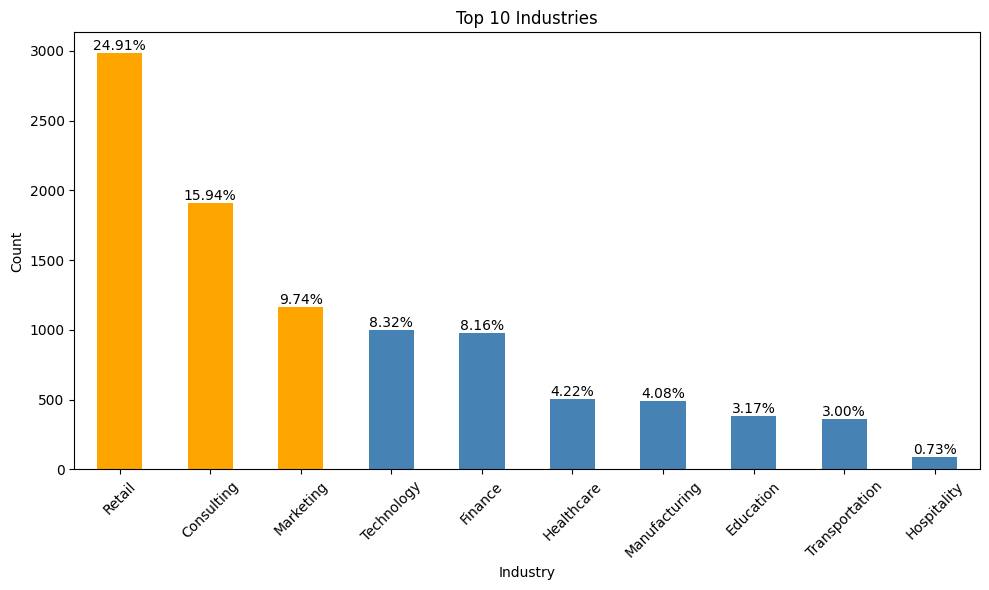

In [97]:
# Visualize the top 10 industries
industry_counts = d2['assigned_industry'].value_counts()
industry_percentages = (industry_counts / len(d2)) * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = industry_counts.plot(kind='bar', color=['orange' if i < 3 else 'steelblue' for i in range(len(industry_counts))])
plt.title("Top 10 Industries")
plt.xlabel("Industry")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Adding percentages at the top of each bar
for i, v in enumerate(industry_counts):
    percentage = industry_percentages[i]
    plt.text(i, v, f"{percentage:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [98]:
skills = d2['skills']
skills = skills.astype(str)
skills = skills.dropna().str.split(', ')
# Flatten the list of skills and remove empty or whitespace-only skills
all_skills = [skill.strip() for sublist in skills for skill in sublist if skill.strip() != '']  # and revove the empty strings
# Calculate skill frequencies
skill_frequencies = Counter(all_skills)

# Exclude missing values from the skill frequencies
skill_frequencies = {skill: frequency for skill, frequency in skill_frequencies.items() if skill != 'nan'}

# Sort the skill frequencies in descending order
sorted_skills = sorted(skill_frequencies.items(), key=lambda x: x[1], reverse=True)

# Select the top N skills
top_skills = sorted_skills[:15]  # Change the number as per your requirement

# Print the top skills and their frequencies
for skill, frequency in top_skills:
    print(skill, "-", frequency)

Excel - 1871
Python - 1668
SQL - 1170
JavaScript - 1097
HTML - 1022
Word - 940
PowerPoint - 885
CSS - 824
Tableau - 783
Communication - 765
Microsoft Office - 686
Project Management - 673
Microsoft Office Suite - 639
Git - 629
Trello - 587


###  Determine trends in users' skills

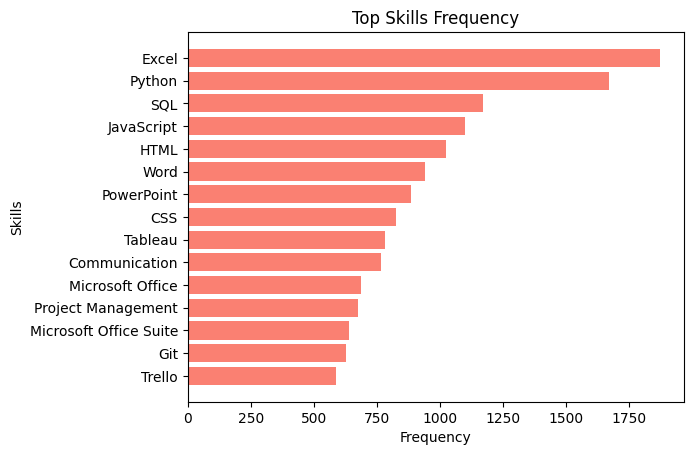

In [100]:
# Extract the skills and frequencies, excluding empty skills
skills = [skill for skill, _ in top_skills]
frequencies = [frequency for skill, frequency in top_skills]

# Reverse the lists to plot in descending order
skills.reverse()
frequencies.reverse()

plt.barh(skills, frequencies,color='salmon')
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top Skills Frequency')
plt.show()